## Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
movies = pd.read_csv("data/movies.csv")
ratings = pd.read_csv("data/ratings.csv")

In [129]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [130]:
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


We are gonna create a handy function to prepare the data easily when we need to:

In [3]:
def mf_prep(ratings, movies):
    ratings.drop('timestamp',axis=1,inplace=True)
    movies.drop('genres',axis=1, inplace=True)
    
    merged_df = ratings.merge(movies, how='left', on='movieId')
    
    merged_df.userId = merged_df.userId.astype('category').cat.codes.values
    merged_df.movieId = merged_df.movieId.astype('category').cat.codes.values
    
    movie_dict = merged_df.groupby(['movieId']).max().drop(['userId','rating'],axis=1).to_dict()
    
    X = np.array([merged_df['userId'], merged_df['movieId']]).T
    Y = np.array(merged_df['rating'])
    
    return X, Y, movie_dict['title']

    

In [4]:
X, Y, movie_dict = mf_prep(ratings,movies)

## Item-Based Recommender - Matrix Factorization

The idea is to have an utility matrix R where each row is an user instance and each column a movie

In [53]:
R = pd.pivot_table(data=ratings,values='rating',index='userId', columns='movieId')

Our objetive is for our recommender to learn a set of features for the movies (x0,x1,..,xk) and a set of weights for each user (theta0,...,thetak) that represents their preference for each of the features x each movie has.  For a certain user i the dot product x(i,k)*theta(i) should give us a the predicted rating r(i,k) our user would assign to movie k.

Therefore for all users and movies our problem can be translated to finding two matrices X,Theta containing the movie features and user preferences such that X*Theta=R with R our user-rating matrix. This is called Matrix Factorization and how we approach it will greatly impact the scalability and speed of our Recommender.

However, creating this matrix explicitly takes a lot of computing power and great amounts of RAM memory. One of the advantages of matrix factorization is to reduce
this matrix into two smaller matrices (it is fundamentally dimensionality reduction). One of the advantages of using Stochastic Gradient Descent is that we will perform our calculations for each user-rating pair, therefore calculating this matrix will not be necessary.

Our matrix factorization will then reduce to find the appropiate U and M matrices of size nxk and mxk respectively. Where k is the number of latent features for movie and user taste, a parameter we can tweak to increase our model's performance

We need to be smart about how we split the dataset. Every user and movie we have available should be present in the training set, to ensure that we make a stratify split by user and then make sure every movie is in the training set, moving instances from the test set.

In [5]:
def mf_split(X,y, test_size=0.22):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = test_size, stratify=X[:,0])
    
    movie_train_index = X_train[:,1]
    movie_test_index = X_test[:,1]
    deleted_index = []

    for index,element in enumerate(movie_test_index):
        if element not in movie_train_index:
            X_train = np.concatenate((X_train,X_test[index,:].reshape((1,2))),axis=0)        
            y_train = np.append(y_train,y_test[index])
            deleted_index.append(index)

    X_test = np.delete(X_test,deleted_index,axis=0)
    y_test = np.delete(y_test,deleted_index)
    
    return X_train, X_test, y_train, y_test
    

In [6]:
X_train, X_test, y_train, y_test = mf_split(X,Y, test_size = 0.22)

## Stochastic Gradient Descent

EXPLAIN HERE SGD, LOSS FUNCTION AND UPDATE

Now let's initialize our matrices and vectors

Now let's test the error on the training set

In [137]:
# np.save('U_matrix', U)

In [138]:
# np.save('M_matrix', M)

## Wrapping our model in scikit-learn object

In [203]:
class MFsgd():
    def __init__(self, latent_features = 25, n_epoch = 30, learning_rate = 0.001,
                 regularization = 0.01, random_state = None,verbose=False):
        
        # Here we initialize relevant parameters our model has to keep track of
        
        self.k = latent_features # number of latent features
        self.n_epoch = n_epoch # number of epochs for training
        self.learning_rate = learning_rate ## learning rate parameter
        self.reg = regularization # regularization parameter
        self.random_state = random_state # random state in random initialization
        self.present_epoch = 0 # present epoch in training
        self.verbose = verbose # parameter to indicate if we want progress feedback during training
        
        
        
    def init_params(self,X,Y):    
        
        np.random.seed(seed=self.random_state) 
        self.r = Y.shape[0] ## number of ratings
        self.n = np.unique(X_train[:,0]).shape[0] # number of unique users
        self.m = np.unique(X_train[:,1]).shape[0] # number of unique movies
        self.U = np.random.rand(self.n,self.k) # Initialize user and latent factor matrix
        self.M = np.random.rand(self.m,self.k) # Initialize user and latent factor matrix
        self.bu= np.random.rand(self.n) # Initialize user bias
        self.bm= np.random.rand(self.m) # Initialize movie bias
        self.mu = np.mean(Y) # Calculate global bias: global mean of ratings
        
    def load_movie_dict(self, movie_dict):
        self.movie_dict = movie_dict
    
    def movie_avg(self,X,Y):
        
        movie_avg_ratings = np.zeros((np.unique(X[:,1]).shape[0],3))
        
        for x in np.unique(X[:,1]):    
            movie_avg_ratings[x,0] = np.average(Y[np.where(X[:,1]==x)])
            movie_avg_ratings[x,1] = np.sum(X[:,1] == x)
            movie_avg_ratings[x,2] = x
            
        self.movie_avg_ratings = movie_avg_ratings
        
    
    def popularity_recommender(self,min_score=4, min_ratings=20):
        
        user_movie_ratings = self.movie_avg_ratings        
                  
        recommender_list = user_movie_ratings[user_movie_ratings[:,0] > min_score]
        user_movie_ratings = user_movie_ratings[user_movie_ratings[:,1] > min_ratings]
        user_movie_ratings = user_movie_ratings[user_movie_ratings[:,1].argsort()]
        user_movie_ratings = np.flip(user_movie_ratings,axis=0)
        
        list1 = list(np.random.choice(user_movie_ratings[:10,2], size=5,replace=False))
        list2 = list(np.random.choice(user_movie_ratings[10:30,2], size=5,replace=False))
        final_list= []
        final_list = list1 + list2
        
        
        print_list = []
        
        for movie in final_list:
            print_list.append(self.movie_dict[movie])
            
        return print_list
    
    
    
    def predict_rating(self,user,movie):
        
                 
        return self.mu + self.bu[user]+self.bm[movie] + np.dot(self.U[user],self.M[movie])
    
    
    def transform(self,X):
        
        # Returns the whole predicted ratings vector
        
        size = X[:,0].shape[0]
        y_hat = np.empty([size])
        for elem in range(size):
            user = X[elem,0]
            movie = X[elem,1]
            y_hat[elem] = self.predict_rating(user,movie)
        return y_hat
    
    def calc_error(self,X,Y):
        
        # Calculates RMSE for the given data
                
        size = X[:,0].shape[0]
        se = np.sum(np.square(Y - self.transform(X)))
        mse = se/size
        rmse = np.sqrt(mse)
        return rmse
    
    def single_sgd_step(self,X,Y,index=0):
        
        ## Stochastic Gradient Descent ##
        
        # First declaring user and movie
        if X.ndim == 2:
            user = X[index,0]
            movie = X[index,1]
        else:
            user = X[0]
            movie = X[1]
        lr = self.learning_rate
        l = self.reg
            
        # With the help of the previously defined predict_rating function
        # we calculate the error between our prediction and the training labels
            
        prediction = self.predict_rating(user,movie)
        err = Y[index] - prediction ## 
            
        # We update the model parameters accordingly
            
        self.U[user] += lr*(err*self.M[movie]-l*self.U[user])
        self.M[movie] += lr*(err*self.U[user]-l*self.M[movie])
        self.bu[user] += lr*(err - l*self.bu[user])
        self.bm[movie] += lr*(err - l*self.bm[movie])
    
    def sgd_step(self,X,Y):
        
        # This function performs SGD once for every user rating pair in the dataset       
        
        for elem in range(self.r):        
                        
            self.single_sgd_step(X,Y,elem)
            
            
    def fit(self,X,Y):
        
        
        self.init_params(X,Y)
        self.movie_avg(X,Y)
        for epoch in range(self.n_epoch):
            self.present_epoch += 1
            if self.verbose:
                print('Training epoch... ({}/{})'.format(self.present_epoch,self.n_epoch))
            self.sgd_step(X,Y)
            
    def add_user_rating(self,X=None,Y=None,n_epoch=5):
        
        if (X is None) and (Y is None):
            new_user = np.zeros((1,self.k))
            self.U = np.concatenate((self.U,new_user), axis=0)
            
        elif (X is not None) and (Y is not None):
            user = X[0]
            movie = X[1]
            rating = Y
            if user >= self.U.shape[0]:
                self.U = np.concatenate((self.U, np.random.rand(1,self.k)),axis=0)
                for epoch in range(n_epoch):
                    self.single_sgd_step(X,Y)
            else:
                if np.sum(self.U[user] == 0) == self.k:
                    
                    self.U[user] = np.random.rand(1,self.k)                    
                    for epoch in range(n_epoch):
                        self.single_sgd_step(X,Y)
                else:
                    for epoch in range(n_epoch):
                        self.single_sgd_step(X,Y)
                
            
            ## NEED TO ADD THE USER BIAS TOO!!
            
    def recommend(self,user):
        if np.sum(self.U[user] == 0) == self.k:
            
            return self.popularity_recommender()
            
        
        else:
            
            user_ratings = self.mu + self.bu[user]+ (self.bm + self.U[user] @ (self.M).T)
            
            movie_ratings = np.copy(self.movie_avg_ratings)
            movie_ratings[:,0] = user_ratings
            movie_ratings = movie_ratings[movie_ratings[:,0].argsort()]
            movie_ratings = np.flip(movie_ratings,axis=0)
            movie_list = list(movie_ratings[:10,2])
            print_list= []
            
            for movie in movie_list:
                print_list.append(self.movie_dict[movie])
            return print_list
    
            

In [204]:
mf = MFsgd(random_state=42,n_epoch=30, latent_features=30, learning_rate = 0.01, regularization=0.1)
mf.fit(X_train,y_train)
mf.calc_error(X_test,y_test)

0.8748214728027472

Now let's see how the RMSE changes over each epoch on both the training and test sets

In [14]:
n_epoch=150
mf = MFsgd(random_state=42,latent_features=30)
mf.init_params(X_train,y_train)
training_error = []
val_error = []
for epoch in range(n_epoch):
    mf.sgd_step(X_train,y_train)
    training_error.append(mf.calc_error(X_train, y_train))
    val_error.append(mf.calc_error(X_test, y_test))

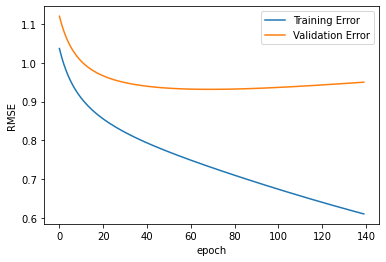

In [15]:
plt.plot(training_error[10:],label='Training Error')
plt.plot(val_error[10:], label='Validation Error')
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [16]:
np.min(val_error)

0.9314383026507431

Despite the training error continuously decreasing, the validation error reaches a minimun at 75 epochs and then begins to climb again due to overfitting. We will fit our model from now on up to 75 epochs to avoid overfitting.

## Searching for the best parameters

The next sensible step is to find a good combination of hyperparameters to further increase the model accuracy. We will perform a grid search for the learning rate, regularization and number of latent features. Due to the time it will take to perform this search for a reasonable number of combinations, we will train each model for just 30 epochs

In [18]:
learning_rate = [0.01,0.001]
regularization = [0.1, 0.01]
latent_features = [20,30,40]
n_epoch= 50
for lr in learning_rate:
    for l in regularization:
        for k in latent_features:
            mf = MFsgd(random_state=42,latent_features=k,n_epoch=n_epoch, regularization=l, learning_rate=lr)
            mf.fit(X_train,y_train)
            rmse = mf.calc_error(X_test,y_test)
            print('learning_rate: {}'.format(lr) + ' | ' + 'regularization: {}'.format(l) +
                  ' | ' + 'latent_features: {}'.format(k) + ' | '  + 'val_rmse: {}'.format(rmse))

learning_rate: 0.01 | regularization: 0.1 | latent_features: 20 | val_rmse: 0.8547681883839988
learning_rate: 0.01 | regularization: 0.1 | latent_features: 30 | val_rmse: 0.8576722214166141
learning_rate: 0.01 | regularization: 0.1 | latent_features: 40 | val_rmse: 0.8565306062696357
learning_rate: 0.01 | regularization: 0.01 | latent_features: 20 | val_rmse: 1.004354262200486
learning_rate: 0.01 | regularization: 0.01 | latent_features: 30 | val_rmse: 1.0392064040166922
learning_rate: 0.01 | regularization: 0.01 | latent_features: 40 | val_rmse: 1.0507598809980456
learning_rate: 0.001 | regularization: 0.1 | latent_features: 20 | val_rmse: 0.8947266799437251
learning_rate: 0.001 | regularization: 0.1 | latent_features: 30 | val_rmse: 0.9051399805819728
learning_rate: 0.001 | regularization: 0.1 | latent_features: 40 | val_rmse: 0.9111740247672233
learning_rate: 0.001 | regularization: 0.01 | latent_features: 20 | val_rmse: 0.916647306254893
learning_rate: 0.001 | regularization: 0.01 

There are quite a few relevant conclusions that can be drawn from the grid search:

1. It seems our previous learning rate of 0.001 led us to get stuck in a local minimum, so a valueof 0.01 or even a proper learning rate schedule could greatly improve performance.

2. A higher regularization parameter also seems to be beneficial as ot probably reduces overfitting problems

3. The number of latent features doesn't seem very impactful at least in the considered range, however we can see k=40 underperforms all else being equal. So a lower value like 20 or 30 seems more appropiate



Our best hyperparameters seem to be learning_rate=0.01, regularization=0.1 and latent_features=20. It would be interesting to see if a training rate schedule could improve performance further.

We are gonna try a very simple one. It will start at 0.01 and will linearly decrease to 0.001 in a span of 75 epochs.

In [19]:
def lr_schedule(n,lr_start,lr_end,span):
    c0=lr_start
    c1=(lr_end-lr_start)/span
    return c0 + (c1*n)

Let's see how it performs

In [20]:
lr_start = 0.01
lr_end = 0.001

n_epoch=75
mf = MFsgd(random_state=42,latent_features=30,regularization=0.1)
mf.init_params(X_train,y_train)
training_error = []
val_error = []
for epoch in range(n_epoch):
    mf.learning_rate = lr_schedule(epoch,lr_start,lr_end,n_epoch)
    mf.sgd_step(X_train,y_train)
    training_error.append(mf.calc_error(X_train, y_train))
    val_error.append(mf.calc_error(X_test, y_test))

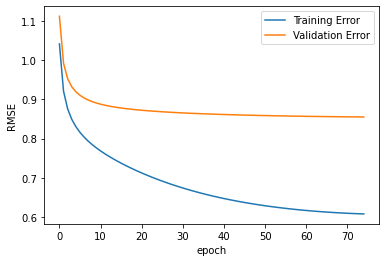

In [21]:
plt.plot(training_error,label='Training Error')
plt.plot(val_error, label='Validation Error')
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [22]:
np.min(val_error)

0.8551648039394635

Our learning rate schedule gave us just a marginal decrease in error, so we will do without it for the time being.

In [23]:
mf =MFsgd(random_state=42,n_epoch=60, latent_features=20, learning_rate = 0.01, regularization=0.1)

In [24]:
mf.fit(X_train,y_train)

In [25]:
mf.calc_error(X_test,y_test)

0.8531280810844839

## Adding a new user

One of the main drawbacks of collaborative filtering recommenders is the cold start problem. That is, what do we recommend an absolutely new user with no interactions?
We will make a very simple fix for that situation, recommending a set of popular movies with a high enough rating. This is just one way to do it, and there are more complex models which take advantage of any other data on the user or movies.

In [205]:
mf.load_movie_dict(movie_dict)

In [230]:
recommendations = mf.recommend(100)

In [231]:
recommendations

['Belle époque (1992)',
 'Black Tar Heroin: The Dark End of the Street (2000)',
 'High and Low (Tengoku to jigoku) (1963)',
 'The Wait (2015)',
 'Faster (2010)',
 'Before Night Falls (2000)',
 'Come and See (Idi i smotri) (1985)',
 'Wristcutters: A Love Story (2006)',
 'Seve (2014)',
 "My Architect: A Son's Journey (2003)"]

In [232]:
mf.add_user_rating()

In [255]:
recommendations = mf.recommend(610)

In [256]:
recommendations

['Silence of the Lambs, The (1991)',
 'Forrest Gump (1994)',
 'Fight Club (1999)',
 'Matrix, The (1999)',
 'Shawshank Redemption, The (1994)',
 'Toy Story (1995)',
 'Star Wars: Episode VI - Return of the Jedi (1983)',
 'Shrek (2001)',
 'True Lies (1994)',
 'Fugitive, The (1993)']

In [ ]:
new_user_x = np.array([610,])
new_user_y = np.array([5])

In [ ]:
mf.add_user_rating()

# 25M Dataset

In [4]:
ratings25m = pd.read_csv("data/ratings25m.csv")
ratings25m.drop('timestamp',axis=1,inplace=True)
ratings25m.userId = ratings25m.userId.astype('category').cat.codes.values
ratings25m.movieId = ratings25m.movieId.astype('category').cat.codes.values
X = np.array([ratings25m['userId'], ratings25m['movieId']]).T
Y = np.array(ratings25m['rating'])


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, stratify=X[:,0])

In [6]:
mf_25m = MFsgd(random_state=42,n_epoch=1, latent_features=30,learning_rate=0.01,regularization=0.1,verbose=True)

In [7]:
mf_25m.fit(X_train,y_train)

Training epoch... (1/1)


In [8]:
mf_25m.calc_error(X_test,y_test)

NameError: name 'mf' is not defined